# M044_2024_12_04_09_30

In [58]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from scipy.io import loadmat
from typing import Union, List

# pyaldata
sys.path.append("/home/zms24/Desktop") 
import PyalData.pyaldata as pyal # type:ignore

# tools functions
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from tools.curbd import curbd
from tools.dsp.preprocessing import preprocess
from tools.rnn_and_curbd import rnn as rnnz
from tools.rnn_and_curbd import plotting as pltz
from tools.rnn_and_curbd import model_analysis as analyz
from tools.rnn_and_curbd import curbd as curbdz

# Reload modules
importlib.reload(rnnz)
importlib.reload(pltz)
importlib.reload(analyz)
importlib.reload(curbdz)

np.random.seed(44)

## Load RNN model and df

In [21]:
filename = 'rnn_model_M044_2024_12_04_09_30.mat'
path = os.path.join("/home/zms24/Desktop/rnn_models/", filename)

data = loadmat(path, simplify_cells=True)  # works in SciPy >= 1.7
rnn_model = data['rnn_model']

In [88]:
def process_pyal_files(pyal_files: Union[str, List[str]], rnn_model, root_dir: str = "/data/raw") -> dict:
    if isinstance(pyal_files, str):
        pyal_files = [pyal_files]

    dfs = []
    for pyal_file in pyal_files:
        # Extract subject ID and session ID
        subject_id = pyal_file.split("_")[0]
        session_id = "_".join(pyal_file.split("_")[1:-1])  # everything between subject and 'pyaldata.mat'
        
        # Construct full path: /data/raw/<subject>/<session>/<file>
        data_dir = os.path.join(root_dir, subject_id, f"{subject_id}_{session_id}")
        fname = os.path.join(data_dir, pyal_file)

        df = pyal.mat2dataframe(fname, shift_idx_fields=True)
        dfs.append(df)

    # Combine and preprocess
    df = pd.concat(dfs, ignore_index=True)
    df_ = preprocess(df, only_trials=True)
    areas = ["M1_rates", "Dls_rates"]
    df_["M1_rates"] = [df_["all_rates"][i][:,300:] for i in range(len(df_))]
    df_["Dls_rates"] = [df_["all_rates"][i][:,0:300] for i in range(len(df_))]

    # Metadata
    areas = [col for col in df_.columns if col.endswith("_rates") and col != "all_rates"]
    # perturbation time
    perturbation_time = df_.idx_sol_on[0]
    perturbation_time_sec = df_.idx_sol_on[0] * df['bin_size'][0]
    # solenoids
    sol_angles = df_.values_Sol_direction.unique()
    sol_angles.sort()
    trial_labels = [f"solenoid {angle}" for angle in sol_angles]
    trial_avg_rates = rnnz.average_by_trial(df_, sol_angles)
    shapes = [arr.shape[0] for arr in trial_avg_rates]

    # do trial avg
    trial_avg_rates = rnnz.average_by_trial(df_, sol_angles)
    concat_rates = np.concatenate(trial_avg_rates, axis=0)
    trial_avg_activity = np.transpose(concat_rates)
    reset_points = rnnz.get_reset_points(df_, trial_avg_activity, areas, rnn_model['params']['dtFactor'])
    regions_arr = rnnz.get_regions(df_, areas)

    return {
        'df_': df_,
        'sol_angles': sol_angles,
        'trial_labels': trial_labels,
        'trial_avg_rates': trial_avg_rates,
        'shapes': shapes,
        'areas': areas,
        'concat_rates': concat_rates,
        'reset_points': reset_points,
        'regions_arr': regions_arr,
        'perturbation_time': perturbation_time,
        'perturbation_time_sec': perturbation_time_sec
    }

In [89]:
pyal_dict = process_pyal_files("M044_2024_12_04_09_30_pyaldata.mat", rnn_model)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)
Trial length: 133


#### Metadata

In [98]:
BIN_SIZE =  rnn_model['dtData']
mouse = filename.split('_')[2]
shapes = pyal_dict['shapes']
trial_labels = pyal_dict['trial_labels']
regions_arr = pyal_dict['regions_arr']
areas = pyal_dict['areas']

## Model analysis

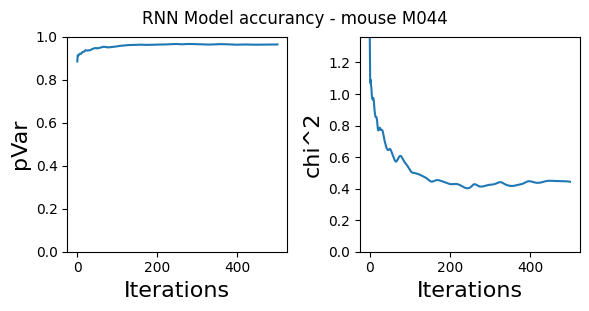

In [17]:
accuracy_figure = pltz.plot_model_accuracy(rnn_model, mouse)

In [14]:
rnn_model_ = rnn_model.copy()
rnn_model_['RNN'] = rnnz.combine_rnn_time_bins(rnn_model)

RNN model output transformed from shape: (474, 2925) to (474, 1463). Matching the original data shape of (474, 1463)


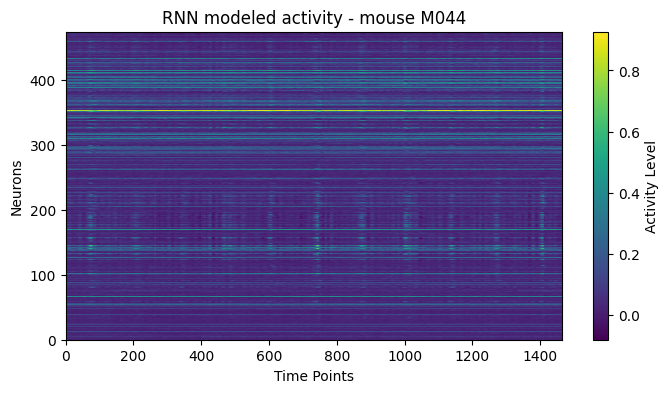

In [15]:
pltz.plot_neuron_activity(rnn_model_['RNN'].T, "RNN modeled activity", mouse)

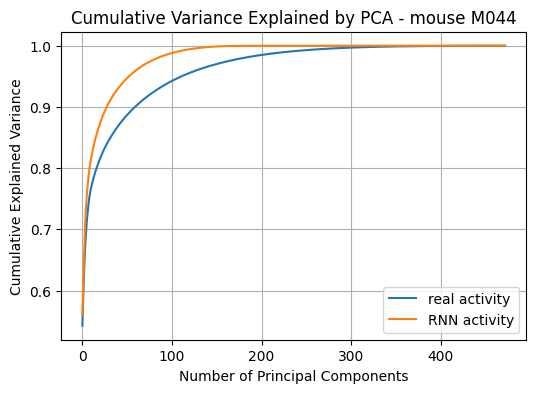

In [16]:
rnn_activity = rnn_model_['RNN'].T
real_activity = rnn_model_['Adata'].T
num_components = rnn_activity.shape[1] - 1

pca_real, pca_data_real = analyz.pca_fit_transform(real_activity, num_components)
pca_rnn, pca_data_rnn = analyz.pca_fit_transform(rnn_activity, num_components)

variance_figure = pltz.plot_pca_cum_var(pca_real, pca_rnn, mouse)

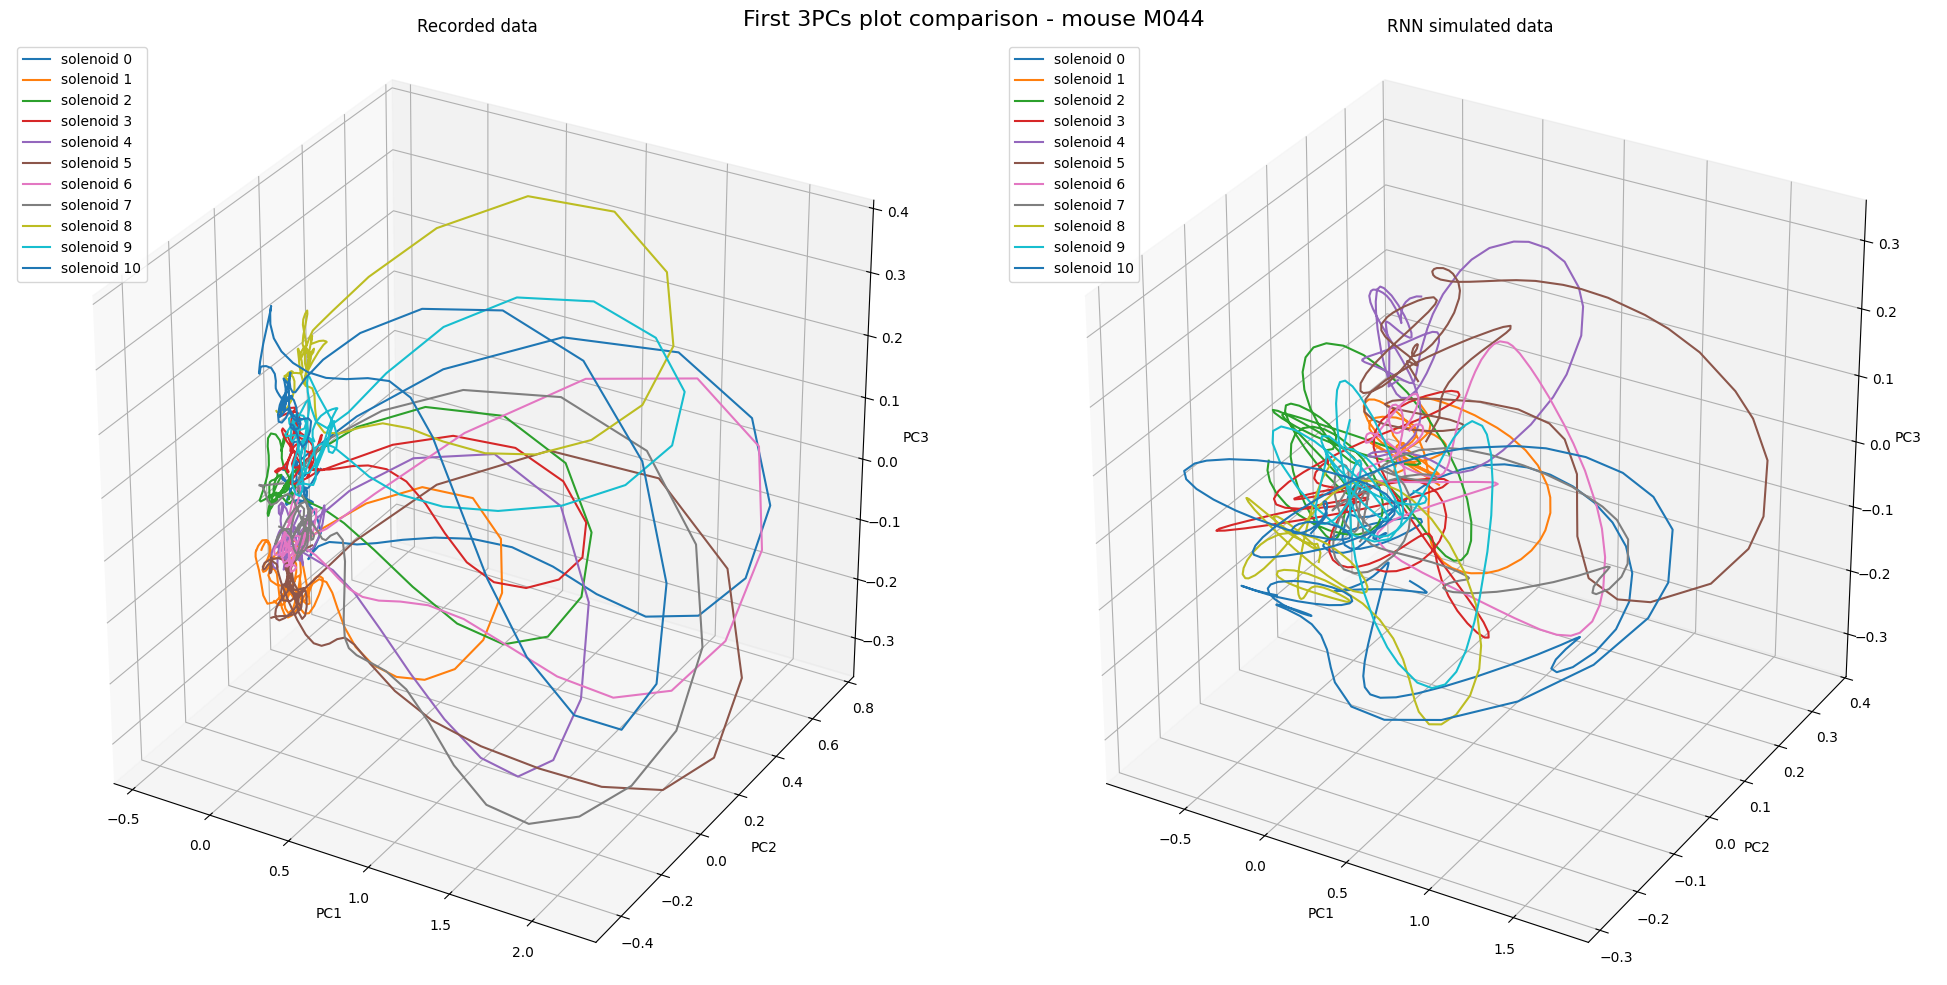

In [81]:
pca_figure = pltz.plot_pca(pca_data_real, pca_data_rnn, shapes, trial_labels, mouse)


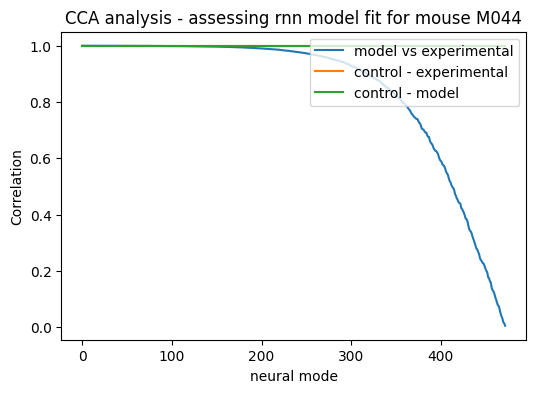

In [82]:
model_cca = analyz.canoncorr(pca_data_real, pca_data_rnn)
ctrl1_cca = analyz.canoncorr(pca_data_real, pca_data_real)
ctrl2_cca = analyz.canoncorr(pca_data_rnn, pca_data_rnn)

cca_figure = pltz.plot_cca(model_cca, ctrl1_cca, ctrl2_cca, mouse)

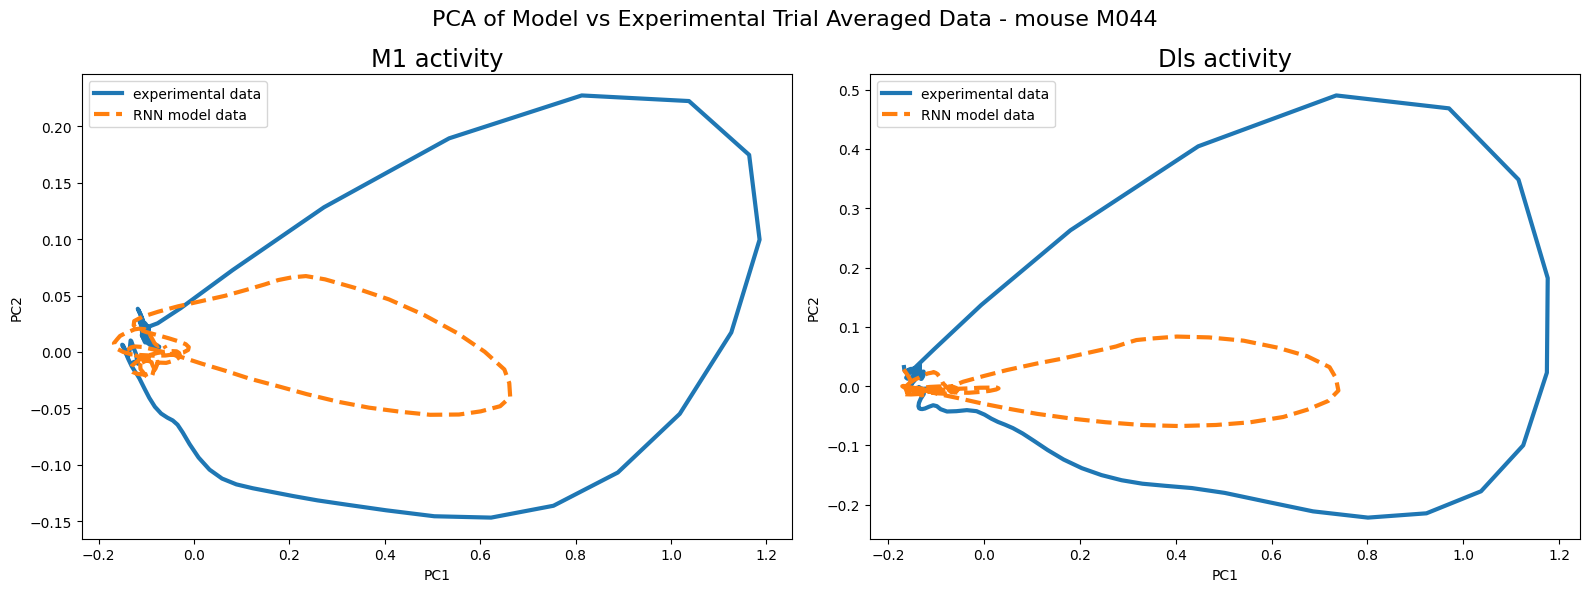

In [83]:
PCA_data_real, pcas_real = analyz.pca_by_region(real_activity, regions_arr)
PCA_data_rnn, pcas_rnn = analyz.pca_by_region(rnn_activity, regions_arr)

figure = pltz.plot_pca_by_region(PCA_data_real, PCA_data_rnn, shapes, regions_arr, mouse)

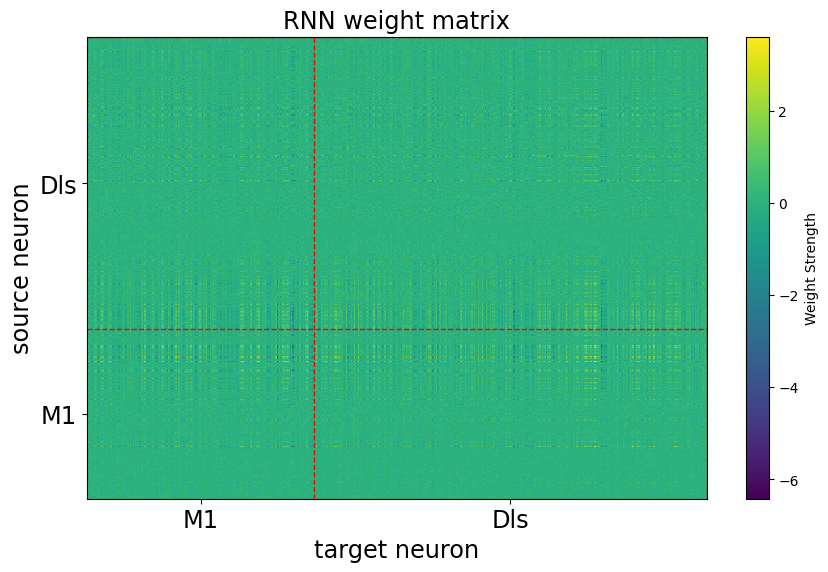

In [84]:
weight_matrix_fig = pltz.plot_rnn_weight_matrix(rnn_model, regions_arr)

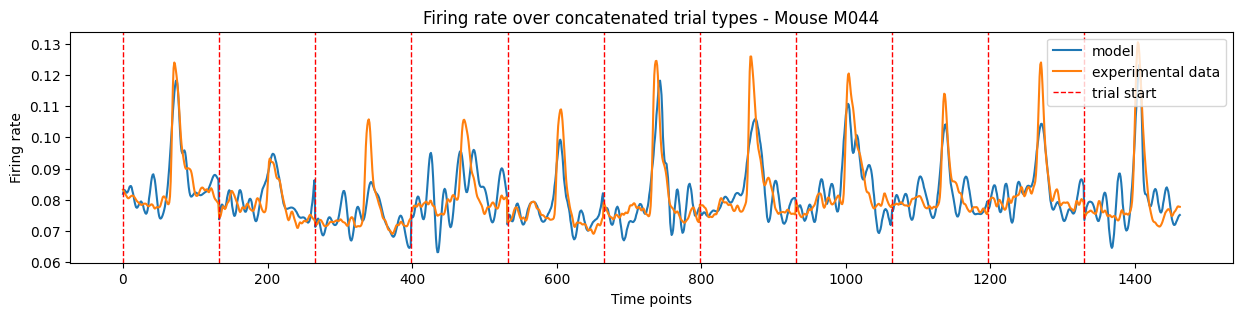

In [85]:
fr_fig = pltz.plot_firing_rates(rnn_model_, pyal_dict['reset_points'], mouse)

/home/zms24/Desktop/earthquake/earthquake-analysis/tools/rnn_and_curbd/plotting.py:276: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  cbar = fig.colorbar(im3, cax=cbar_ax)


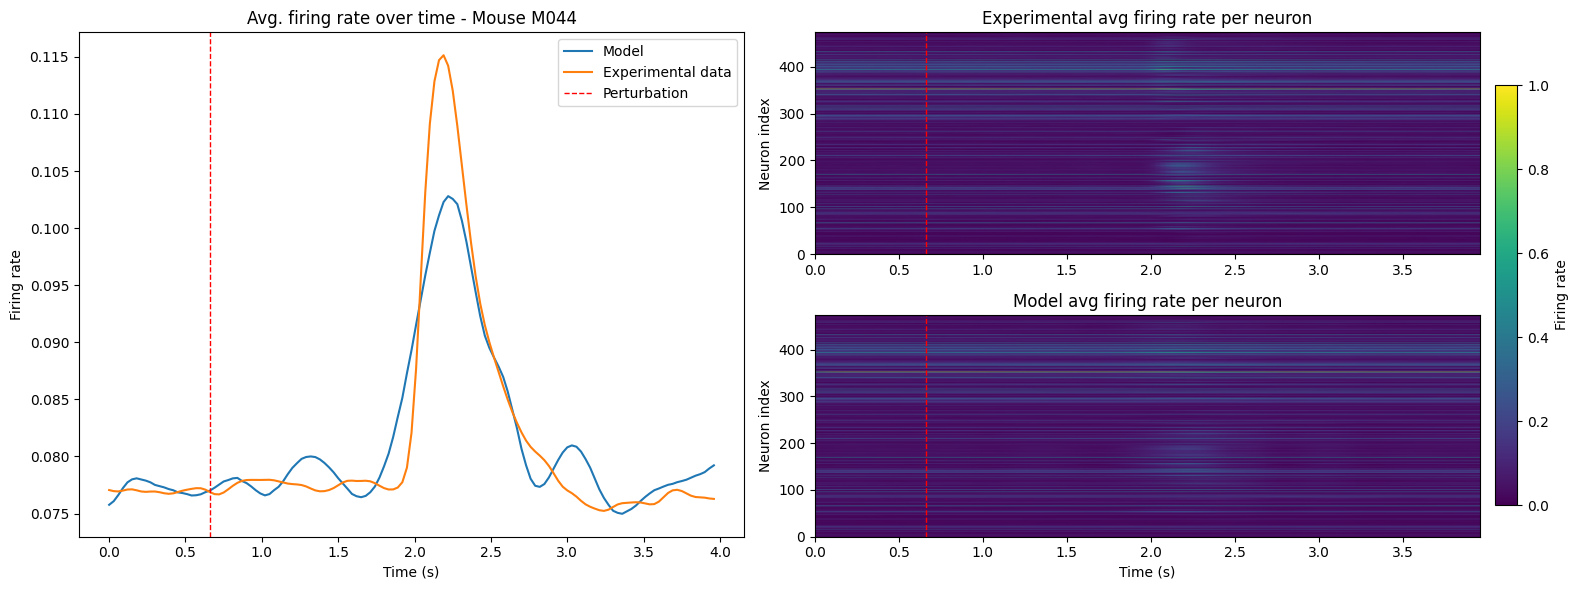

In [99]:
avg_fr_fig = pltz.plot_avg_firing_rates(rnn_model_, shapes, pyal_dict['perturbation_time_sec'], bin_size=BIN_SIZE, mouse_num=mouse)

In [102]:
curbd_arr, curbd_labels = curbd.computeCURBD(rnn_model)
n_regions = curbd_arr.shape[0]
currents, current_labels = curbdz.format_curbd_output(curbd_arr, curbd_labels, n_regions, pyal_dict['reset_points'])

/home/zms24/Desktop/earthquake/earthquake-analysis/tools/rnn_and_curbd/plotting.py:394: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  


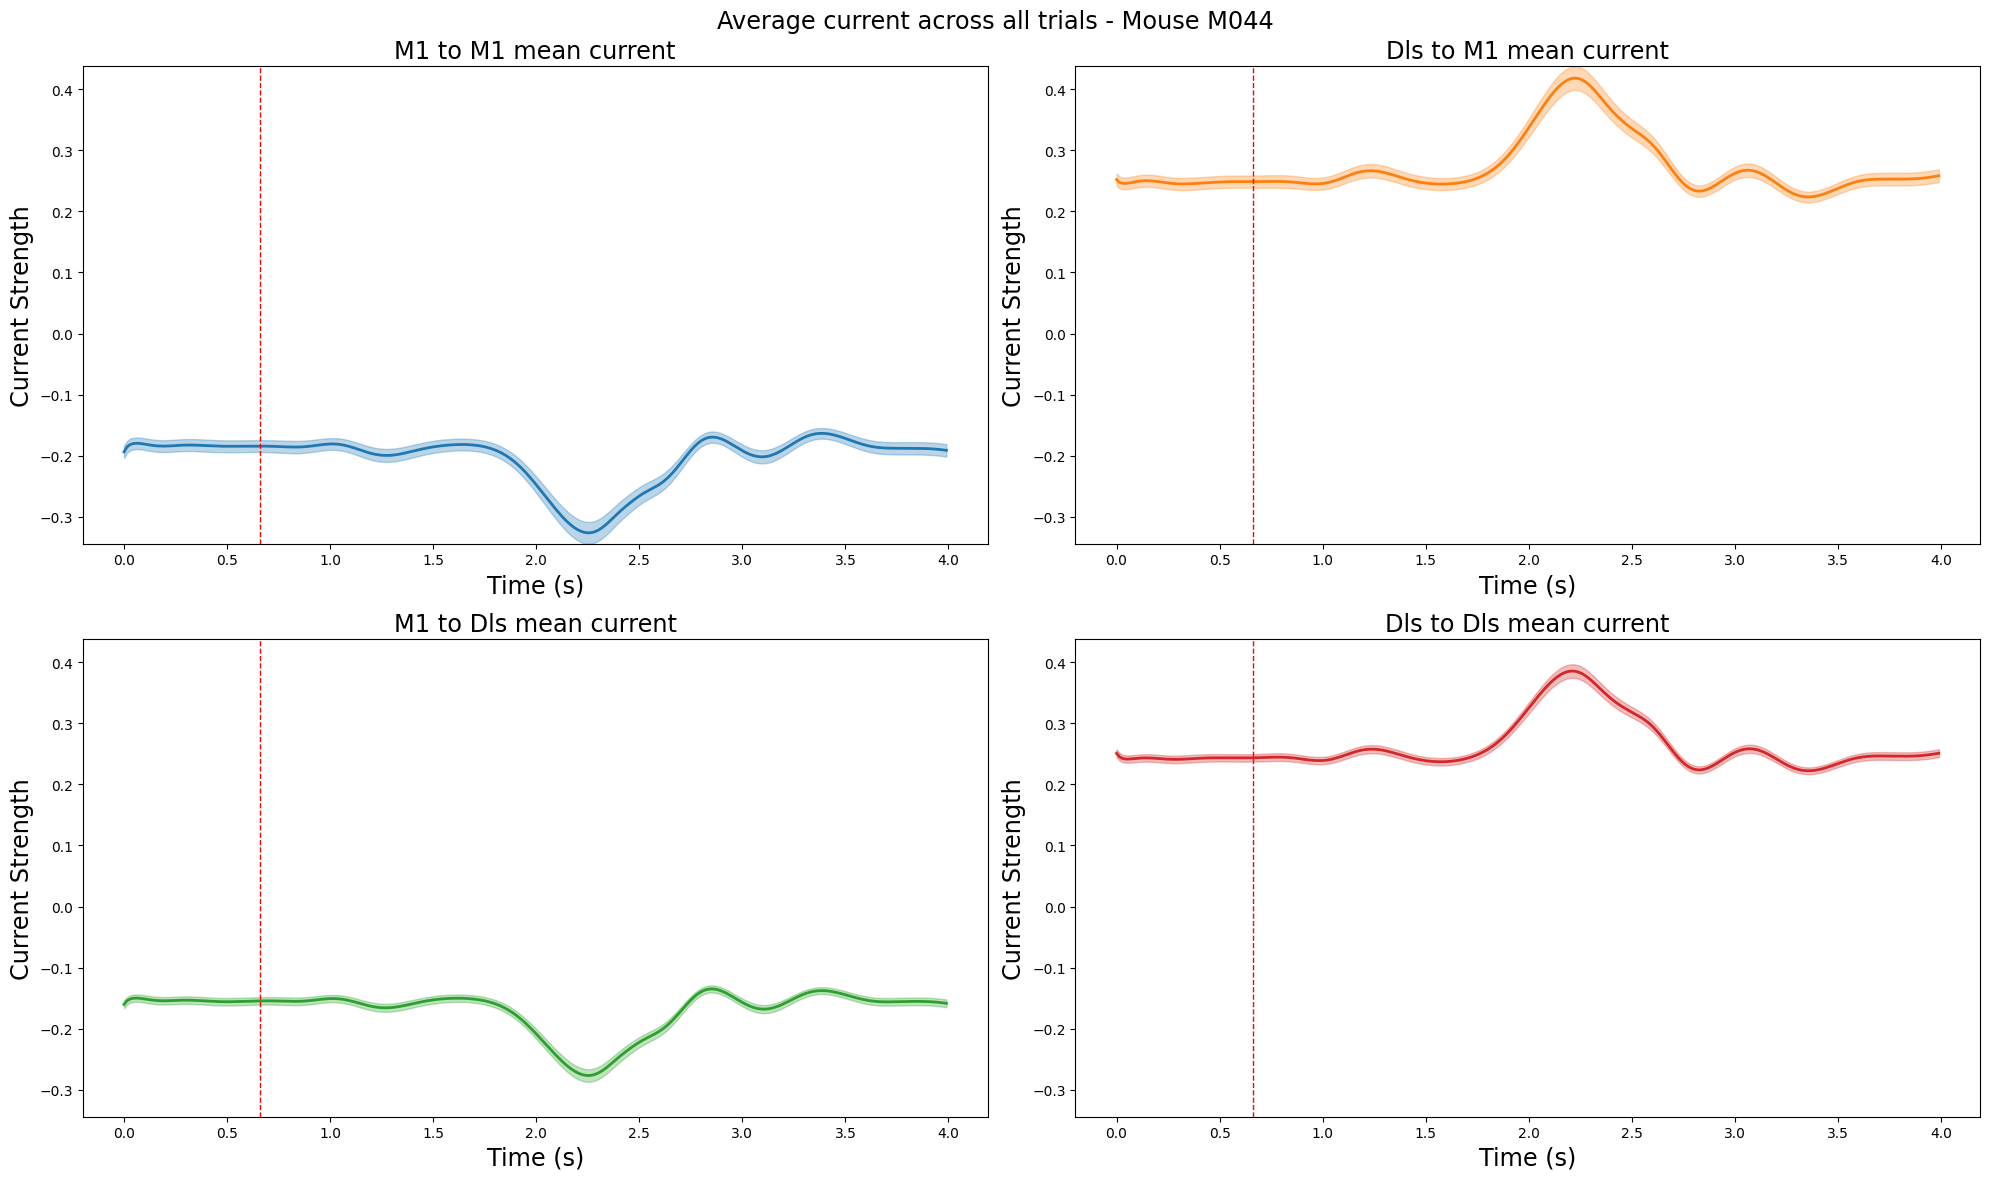

In [103]:
currents_fig = pltz.plot_currents_by_region(currents, current_labels, pyal_dict['perturbation_time_sec'], BIN_SIZE, rnn_model['params']['dtFactor'], mouse)

/home/zms24/Desktop/earthquake/earthquake-analysis/tools/rnn_and_curbd/plotting.py:508: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


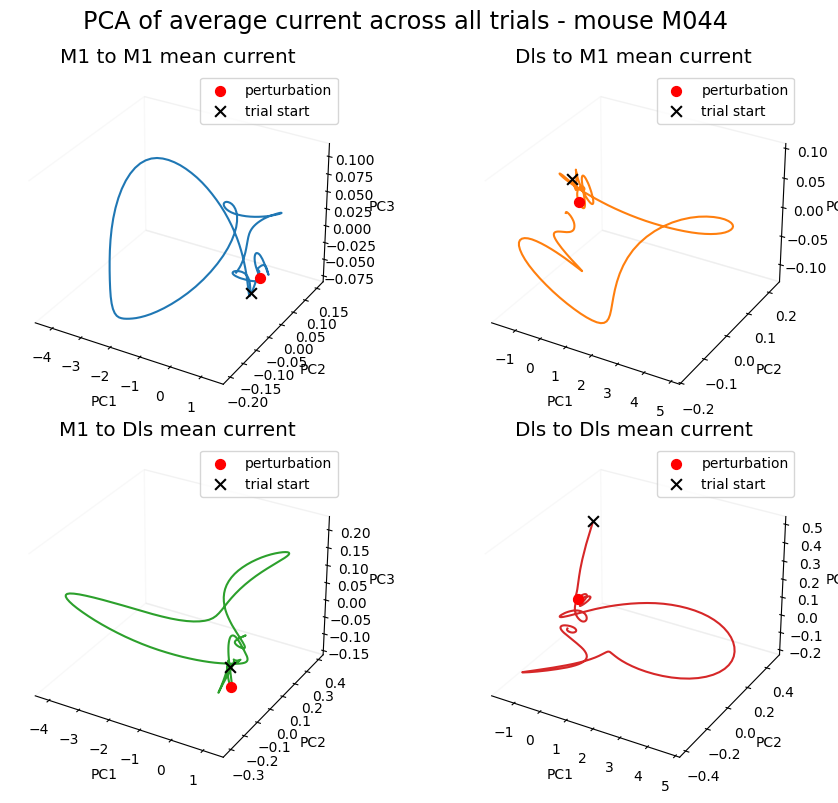

In [105]:
pca_current_fig = pltz.plot_pca_currents(currents, current_labels, pyal_dict['perturbation_time'], mouse)